# TPU enabling
Connect and set up TPU 

In [1]:
# Import TensorFlow and print the imported version
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Connect to the TPU Runtime
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime. Please, change the Colab Runtime Type to TPU o ensure you have not reached Colab usage limits.')

# Define TPU strategy
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0-rc3
Running on TPU  ['10.4.52.10:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.4.52.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.52.10:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Import useful libraries.

In [0]:
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.utils import plot_model

# Load CelebA Dataset
Define fundamental sizes for images, batch etc.

In [3]:
# Image size for image generation
SQUARE_SIZE = 64
NUM_CHANNELS = 3
IMAGE_SIZE = (SQUARE_SIZE, SQUARE_SIZE, NUM_CHANNELS)

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
EPOCHS = 50
BATCH_SIZE = 32 * tpu_strategy.num_replicas_in_sync
BUFFER_SIZE = 60000
Z_SIZE = 100 # Dimension of the latent vector (z)

if NUM_CHANNELS is 3:
  COLOR = "RGB"
else:
  COLOR = "B&W"

"""data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory("", 
                                                                   target_size = IMAGE_SIZE[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )"""

print(f"Will generate {SQUARE_SIZE} x {SQUARE_SIZE} {COLOR} images.")

Will generate 64 x 64 RGB images.


Load dataset from Google Cloud bucket.

In [0]:
AUTO = tf.data.experimental.AUTOTUNE

gcs_pattern = 'gs://celeba-public/tfrecord_*.tfrec'

filenames = tf.io.gfile.glob(gcs_pattern)

def parse_attribute_list(example):
  features = {
      "names": tf.io.FixedLenFeature([], tf.string),
  }

  example = tf.io.parse_single_example(example, features)
  attributes_names = example['names']
  return attributes_names

def get_names():
  record = tf.data.TFRecordDataset('gs://celeba-test/attribute_list.tfrec')
  attributes = record.map(parse_attribute_list)
  att_names = next(attributes.as_numpy_iterator()).decode("utf-8")
  att_names_list = [elem.strip()[1:-1] for elem in att_names.split(',')]
  return att_names_list

att_names_list = get_names()


feature_dict = {
      "filename": tf.io.FixedLenFeature([], tf.string),
      "height": tf.io.FixedLenFeature([], tf.int64),
      "width": tf.io.FixedLenFeature([], tf.int64),
      "depth": tf.io.FixedLenFeature([], tf.int64),
      "image": tf.io.FixedLenFeature([], tf.string),
  }

attributes_dict = dict(zip(att_names_list, [tf.io.FixedLenFeature([], tf.int64) for elem in att_names_list]))

feature_dict.update(attributes_dict) 

def parse_tfrecord(example):
  features = feature_dict
  example = tf.io.parse_single_example(example, features)
  filename = example['filename']
  width = tf.cast(example['width'],tf.int64)
  height = tf.cast(example['height'],tf.int64)
  decoded = tf.image.decode_image(example['image'])  
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [height, width, 3])
  image_tensor = tf.image.resize(image_tensor[45:173,25:153], (IMAGE_SIZE[0], IMAGE_SIZE[1])) # crop and reshape the image 
  #attr_dict = {}
  #for name in att_names_list:
  #  attr_dict[name] = example[name]

  # return filename, image_tensor, attr_dict
  return image_tensor

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO).shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

dataset = load_dataset(filenames)

In [0]:
def count_data_items(dataset):
  # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
  n = 0
  for batch in dataset:
    n = n + len(batch)
  return n

dataset_size = count_data_items(dataset)

Let's look into the dataset we have loaded.

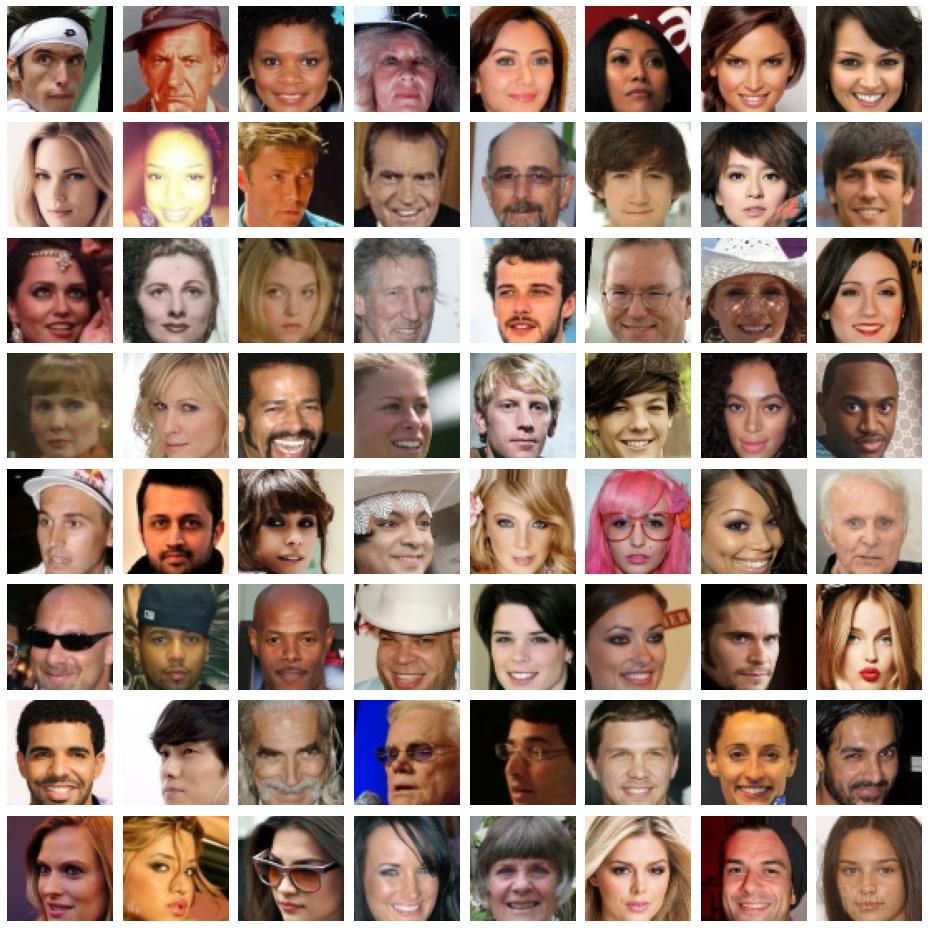

In [8]:
#Function that displays n images
def display_images(images, n):
  plt.figure(figsize=(13,13))
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, i+1)
    # turn off axis
    plt.axis('off')
    plt.imshow(images[i])
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

# Function that returns a dataset iterator
def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

n_images = 8

# Get the dataset iterator
training_viz_iterator = get_dataset_iterator(dataset, n_images**2)

# Display images
images = next(training_viz_iterator)
display_images(images, n_images)

# Model construction
Build VAE model, by first constructing the encoder.

In [0]:
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
    x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

    x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

Construct the decoder.

In [0]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
    x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
    # Adding a sigmoid layer at the end to restrict the outputs 
    # between 0 and 1
    if i < n_layers - 1:
      x = LeakyReLU()(x)
    else:
      x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

Combine Encoder and Decoder in a single model.

In [16]:
# Create Encoder
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_SIZE, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

# Create Decoder
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_SIZE,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 64, 64, 3)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 64)          0   

# Compilation and training
Compile and train the model.


In [25]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
  return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

simple_autoencoder.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError)

# checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)

simple_autoencoder.fit(dataset, epochs = N_EPOCHS, steps_per_epoch=dataset_size // BATCH_SIZE)

Epoch 1/10


ValueError: ignored